In [1]:
import cirq
import qsimcirq

In [2]:
q0, q1 = cirq.LineQubit.range(2)

circuit = cirq.Circuit(cirq.H(q0), cirq.CX(q0, q1))

print("Circuit:")
print(circuit)
print()

Circuit:
0: ───H───@───
          │
1: ───────X───



**cirq 前端+后端 python**  
Cirq is a Python software library for writing, manipulating, and optimizing quantum circuits,  
and then running them on quantum computers and quantum simulators  

**qsim c++写的后端仿真器**  
可以和 cirq结合

**qsimh c++写的可以在多台机器上并行的后端仿真器**  

In [3]:
# cirq做前端 + qsim做后端

#前端
q0, q1 = cirq.LineQubit.range(2)
circuit = cirq.Circuit(cirq.H(q0), cirq.CX(q0, q1))
print("Circuit:")
print(circuit)
print()

# 后端 这个是对cirq的支持
# qsimcirq cirq的专用支持包

print('qsim results:')
qsim_simulator = qsimcirq.QSimSimulator()
qsim_results = qsim_simulator.simulate(circuit)
print(qsim_results)

# 对别的python前端是否能够支持？？？

Circuit:
0: ───H───@───
          │
1: ───────X───

qsim results:
measurements: (no measurements)

qubits: (cirq.LineQubit(0), cirq.LineQubit(1))
output vector: 0.707|00⟩ + 0.707|11⟩


**qsim**  
https://quantumai.google/qsim/overview  c++版本

**qsimcirq**
看看能不能仿照这个，做一个适配的仿真器  
https://github.com/quantumlib/qsim/blob/master/qsimcirq/qsim_circuit.py  
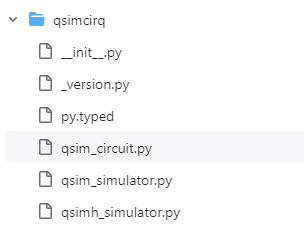   
<!-- 由于cirq自带后端，所以有一些门可以调用   -->
做了一个_translate_操作  
需要弄明白 gate: cirq.ZPowGate 这个是前端还是后端的  
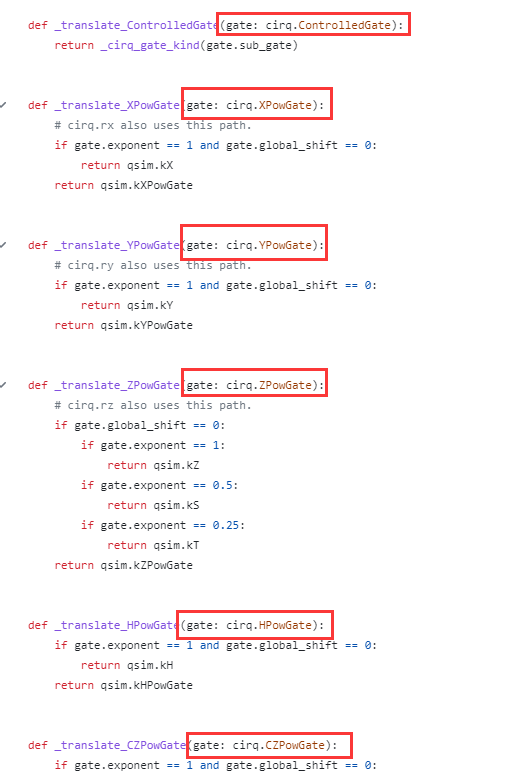  

不同于quafu，他自己写了gate，而qsimcirq的gate是一种基于cirq转换,**是否能够基于其他的前端进行转换？？？**

或者  
    **我们的版本-->cirq前端版本-->qsimcirq仿真**

### 思考
qsimcirq的意义是？？  
    &emsp;看源码就是基于cirq的一些函数



二者有什么差别  
    &emsp; qsimcirq.QSimSimulator()  
    &emsp; cirq.Simulator()  
**qsimcirq更快**  
    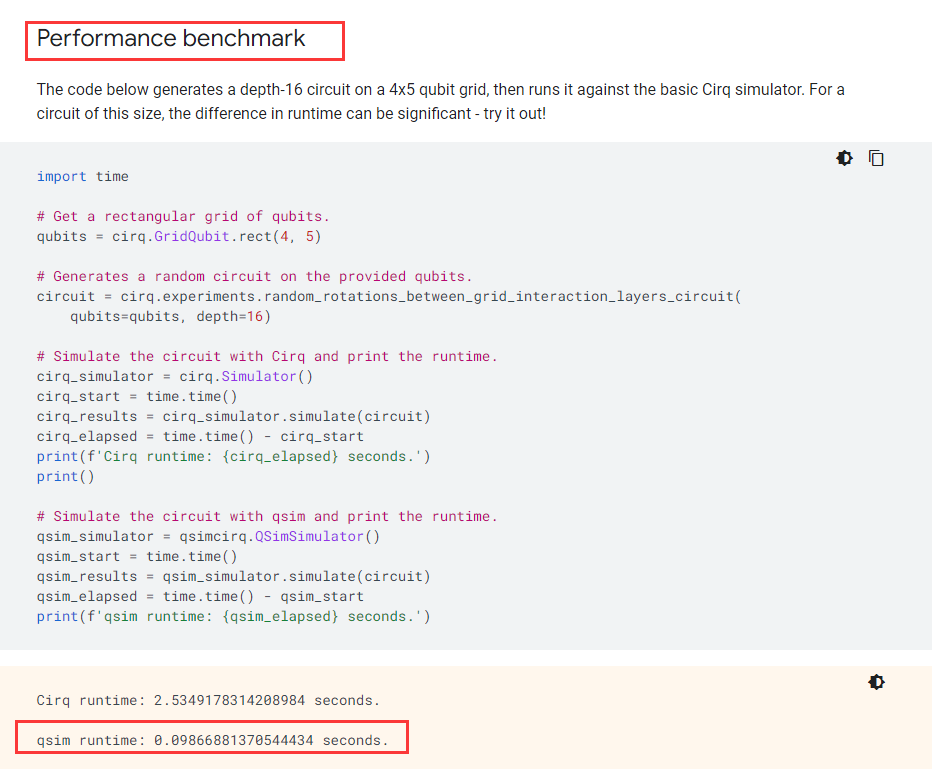  
    &emsp;why？？需要分析qsim后端仿真的流程  

**circuit**  
&emsp;quafu和cirq+qsim和qiskit都是自己有一套前后端适配的  
&emsp;qiskit,quafu都是经过操作生成了QdaoCircuit  get_sub_circ()    
&emsp;因此也可以通过qismcirq生成QdaoCircuit  Gate可以调用cirq里面的，仿照qsim_circuit.py进行转换  
&emsp;*类比qiskit&quafu* **可行**


**simulator**  
初步判断可以，需要后续了解circuit和simulator的流程再说  
https://github.com/quantumlib/qsim/blob/master/qsimcirq/qsim_simulator.py

Make sure the backend simulator support setting initial state vector like [this](https://github.com/Zhaoyilunnn/qdao/blob/main/qdao/quafu/simulator.py#L15)&nbsp;(√)   
[setting initial state vector in qsimcirq](https://github.com/quantumlib/qsim/blob/master/qsimcirq/qsim_simulator.py#L462)  
支持设置初始状态向量的函数 in qsimcirq  

&emsp;simulate_sweep_iter(program,params,qubit_order,initial_state)  
&emsp;simulate_expectation_values_sweep_iter(program,observables,params,qubit_order,initial_state,permit_terminal_measurements)  
&emsp;simulate_moment_expectation_values(program,indexed_observables,param_resolver,qubit_order,initial_state)  




Make sure the backend simulator can [retrieve state vector from result](https://github.com/Zhaoyilunnn/qdao/blob/main/qdao/quafu/simulator.py#L17)&nbsp;(√)  
need-->结果反推状态  
&emsp;[cirq.StateVectorSimulationState()](https://github.com/quantumlib/qsim/blob/master/qsimcirq/qsim_simulator.py#L529)  
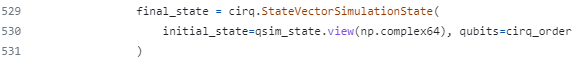  
&emsp;[cirq中的源码 state_vector_simulation_state.py](https://github.com/quantumlib/Cirq/blob/master/cirq-core/cirq/sim/state_vector_simulation_state.py)



In [36]:
#quafu测试
import numpy as np
from quafu import QuantumCircuit

q = QuantumCircuit(5)

q.x(0)
q.x(1)
q.cnot(2, 1)
q.ry(1, np.pi/2)
q.rx(2, np.pi)
q.rz(3, 0.1)
q.cz(2, 3)
q.x(4)


In [154]:
import copy
import logging
from quafu.circuits.quantum_circuit import (ControlledGate, QuantumCircuit,
                                            QuantumGate, SingleQubitGate)

# print(q.num)
# print(q.gates)
# instrs = q.gates
#不限定的话默认为设定qbit
# q.draw_circuit()

# 本地之前的qbit
# num_local = 0
# qset = set(range(num_local))
# print(qset)


def get_instr_qubits(instruction: QuantumGate):
        # QuantumGate 一个gate类
        # instruction.pos拿到量子门的操作行为
        if isinstance(instruction, SingleQubitGate):
            return [instruction.pos]
        return instruction.pos

# for instr in instrs:
#     # print(instr)

#     # 看这个门和那些qbit联系
#     # if isinstance(instr.pos, list):
#     #     instr.pos = instr.pos
#     # else:
#     #     instr.pos = [instr.pos]
#     print(instr.pos)

#     # print(get_instr_qubits(instr))

#     for qb in get_instr_qubits(instr):
#         qset.add(qb)

    # print(instr)
    # print(type(instr))

#把门相关的qbit添加进去
print(qset)

num_primary = 6
sub_circ = QuantumCircuit(num_primary)
sub_circ.draw_circuit()


# real_qubits = sorted(list(qset))
# print(real_qubits)

# qubit_map = {
#     q: i
#     for i, q in enumerate(real_qubits)
# }
# print(qubit_map)



{0, 1, 2, 3, 4}
q[0]   M->c[0]
      
q[1]   M->c[1]
      
q[2]   M->c[2]
      
q[3]   M->c[3]
      
q[4]   M->c[4]
      
q[5]   M->c[5]


In [45]:

#real_qubits -> cbit

for instr in instrs:
    #深拷贝
    #把gate拿走
    new_instr = copy.deepcopy(instr)
    # print(new_instr)
    # 单比特控制和多比特控制
    if isinstance(instr, SingleQubitGate):
        new_pos = qubit_map[instr.pos]
    else:
        new_pos = [qubit_map[q] for q in instr.pos]
        if isinstance(instr, ControlledGate):
                    
                    new_ctrls = [qubit_map[q] for q in instr.ctrls]
                    new_targs = [qubit_map[q] for q in instr.targs]
                    new_instr.ctrls = new_ctrls
                    new_instr.targs = new_targs
    #操作指令生成
    new_instr.pos = new_pos
    



[2]
[2]
[2]
[2]


In [149]:
import cirq
import qsimcirq


circuit = cirq.Circuit()
#qbit为3
qubits = cirq.LineQubit.range(4)
# # list 类型
# print(type(qubits))
# #qbit数
# print(len(qubits))

#加操作
# single-qubit Pauli gates: cirq.X, cirq.Y, and cirq.Z
# a few of the common two-qubit gates:cirq.CZ, cirq.CNOT, cirq.SWAP 
#  cirq.measure -> MeasurementGate
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.H(qubits[1]))
circuit.append(cirq.H(qubits[2]))
circuit.append(cirq.CZ(qubits[1],qubits[2]))
#显示
# print(circuit)

#Gate查看
#继承于AbstractCircuit
# print(circuit.all_operations())
# print(circuit.all_qubits) 
# print(circuit.moments)
# print(circuit.all_qubits)

#qbit数目
# count = 0
# for i in circuit.moments:
#     print(i.operations)
#     for j in i.qubits:
#         # print(j)
#         count+=1
# print(count)

# print(circuit.all_operations())
# 门查看
set =[]
for i in circuit.all_operations():
    # print(type(i))
    set.append(i)
    # print(i)
    # print(i.qubits)
    # print(circuit._first_moment_operating_on(i.qubits))

# print(type(set[0]))
# print(set[])

real_qubits = [0,1,2]
qubit_map = {
            q: i
            for i, q in enumerate(real_qubits)
        }
# print(qubit_map)

print(type(cirq.H(q0)))

for instr in set:
    new_instr = copy.deepcopy(instr)
    # print(instr)
    # x = [qubit_map[q.x] for q in instr.qubits]
    # print(x)
    print(type(new_instr))
    # print(instr.gate)
    # for q in instr.qubits:
    #     print(q)
    #     print(q.x)


circuit.append(new_instr)

print(circuit)


<class 'cirq.ops.gate_operation.GateOperation'>
<class 'cirq.ops.gate_operation.GateOperation'>
<class 'cirq.ops.gate_operation.GateOperation'>
<class 'cirq.ops.gate_operation.GateOperation'>
<class 'cirq.ops.gate_operation.GateOperation'>
0: ───H───────────

1: ───H───@───@───
          │   │
2: ───H───@───@───
